In [24]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import dhtt_msgs.msg
import dhtt_cooking_msgs.msg

import bagToCSV

In [25]:
bag_path: str = '/IdeaProjects/TylerAAMAS/rosbag2_2025_10_08-13_53_06_0.db3'
_message_gen = bagToCSV.get_message_generator(bag_path)
_foo_generator = bagToCSV.filter_status_by_node_names(_message_gen, {})
set_of_nodes: set[str] = set()
for msg in _foo_generator:
    if 'Make' in msg.node_name:
        set_of_nodes.add(msg.node_name)
print(set_of_nodes)

# see bagToCSV.ReducedNodeMsg
_message_gen = bagToCSV.get_message_generator(bag_path)  # reset the stream
my_dataset_generator = bagToCSV.filter_status_by_node_names(_message_gen, set_of_nodes)

[INFO] [1759958654.111603673] [rosbag2_storage]: Opened database '/IdeaProjects/TylerAAMAS/rosbag2_2025_10_08-13_53_06_0.db3' for READ_ONLY.


{'MakePastaWithTomatoSauce_129', 'MakePastaWithTomatoSauce_58', 'MakePastaWithTomatoSauce_210', 'MakePastaWithTomatoSauce_283', 'MakePastaWithTomatoSauce_2'}


## Resource Use Over Time

In [26]:
################ Chatbot special ################
data = ((x.id, x.timestamp, x.node_name, x.num_resources) for x in my_dataset_generator)

# Convert to DataFrame
df = pd.DataFrame(data, columns=["id", "timestamp", "node_name", "counter"])

# Sort by timestamp and node
df = df.sort_values(by=["timestamp", "node_name"])

# Pivot the data with forward fill to handle missing values
df_pivot = df.pivot_table(index="timestamp", columns="node_name", values="counter", aggfunc="last")
df_pivot = df_pivot.ffill().fillna(0)

[INFO] [1759958655.933392930] [rosbag2_storage]: Opened database '/IdeaProjects/TylerAAMAS/rosbag2_2025_10_08-13_53_06_0.db3' for READ_ONLY.


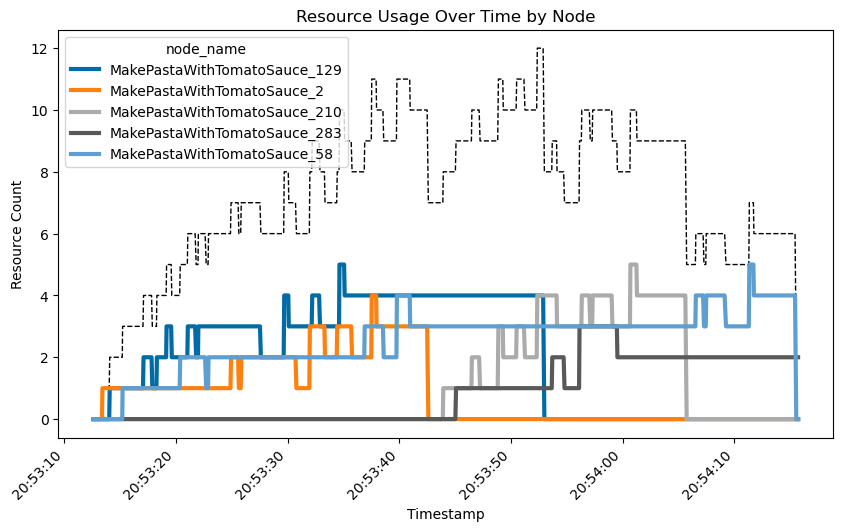

In [27]:
# Plot stacked bar chart
plt.style.use('tableau-colorblind10')
# fig, (ax, ax1) = plt.subplots(2, 1, figsize=(20, 20), sharex=True)
fig, ax = plt.subplots(figsize=(10, 6))

# looks better when the solid lines go over the dashed line and are thicker
df_pivot.sum(axis=1).plot(style='--', label='Total', linewidth=1, color='black')
df_pivot.plot(kind="line", stacked=False, ax=ax, linewidth=3)

# Set labels and title
ax.set_title("Resource Usage Over Time by Node")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Resource Count")
plt.xticks(rotation=45)
# plt.tight_layout()
plt.savefig("foo.png")
plt.show()

## Time to complete

```
let start_time = inf
let end_time = 0
for message in messages:
    if message.status != working: skip
    if message.timestamp < start_time: start_time = message.timestamp
    if message.timestamp > end_time: end_time = message.timestamp

```

In [28]:
# Remember, we are streaming the messages, so need to re-init after using them up above
_message_gen = bagToCSV.get_message_generator(bag_path)
my_dataset_generator = bagToCSV.filter_status_by_node_names(_message_gen, set_of_nodes)

In [29]:
data = ((x.id, x.timestamp, x.node_name, x.node_status) for x in my_dataset_generator)

df = pd.DataFrame(data, columns=["id", "timestamp", "node_name", "node_status"])
df = df.loc[df['node_status'] == dhtt_msgs.msg.NodeStatus.WORKING]

df = df.sort_values(by=["timestamp"])

[INFO] [1759958657.865792078] [rosbag2_storage]: Opened database '/IdeaProjects/TylerAAMAS/rosbag2_2025_10_08-13_53_06_0.db3' for READ_ONLY.


In [30]:
start_time = df.iloc[0].timestamp
end_time = df.iloc[-1].timestamp
print(start_time, end_time)

time_to_complete = end_time - start_time
print(f'Time to complete: {time_to_complete}')

2025-10-08 20:53:12.696744045 2025-10-08 20:54:15.429993967
Time to complete: 0 days 00:01:02.733249922


## Burst time
```
construct map of node names to list of start_stop pairs
calculate time delta for each pair
average over all
```

In [31]:
# Remember, we are streaming the messages, so need to re-init after using them up above
_message_gen = bagToCSV.get_message_generator(bag_path)
my_dataset_generator = bagToCSV.filter_status_by_node_names(_message_gen, set_of_nodes)

In [32]:
data = ((x.id, x.timestamp, x.node_name, x.node_status) for x in my_dataset_generator)
node_to_timepair: dict[str, list[tuple]] = dict.fromkeys(set_of_nodes, [])

df = pd.DataFrame(data, columns=["id", "timestamp", "node_name", "node_status"])
df = df.sort_values(by=["timestamp"])

[INFO] [1759958659.713904423] [rosbag2_storage]: Opened database '/IdeaProjects/TylerAAMAS/rosbag2_2025_10_08-13_53_06_0.db3' for READ_ONLY.


In [33]:
for _, row in df.iterrows():
    entry: list[tuple] = node_to_timepair[row['node_name']]

    if row['node_status'] == dhtt_msgs.msg.NodeStatus.WORKING:  # looking to open a timepair
        if len(entry) == 0 or (entry[-1][0] is not None and entry[-1][1] is not None):
            entry.append((row['timestamp'], None))
        else:
            continue

    if row['node_status'] != dhtt_msgs.msg.NodeStatus.WORKING:  # looking to complete a timepair
        if len(entry) == 0:
            continue
        if entry[-1][0] is not None and entry[-1][1] is None:
            entry[-1] = (entry[-1][0], row['timestamp'])
        else:
            continue

In [34]:
all_deltas = [
    end - start
    for pairs in node_to_timepair.values()
    for start, end in pairs if all(pairs)
]
avg_delta = np.mean(all_deltas)
max_delta = np.max(all_deltas)
min_delta = np.min(all_deltas)

print(f'Avg burst length: {avg_delta}\nMax: {max_delta}\nMin: {min_delta}')

Avg burst length: 0 days 00:00:00.071603227
Max: 0 days 00:00:00.295380436
Min: 0 days 00:00:00.028133216


## Recipe latency (window time)

In [35]:
# Remember, we are streaming the messages, so need to re-init after using them up above
_message_gen = bagToCSV.get_message_generator(bag_path)
my_dataset_generator = bagToCSV.filter_status_by_node_names(_message_gen, set_of_nodes)

In [36]:
data = ((x.id, x.timestamp, x.node_name, x.node_status) for x in my_dataset_generator)
node_to_timepair: dict[str, tuple] = dict.fromkeys(set_of_nodes, (None, None))

df = pd.DataFrame(data, columns=["id", "timestamp", "node_name", "node_status"])
df = df.sort_values(by=["timestamp"])

[INFO] [1759958661.692076219] [rosbag2_storage]: Opened database '/IdeaProjects/TylerAAMAS/rosbag2_2025_10_08-13_53_06_0.db3' for READ_ONLY.


In [37]:
for _, row in df.iterrows():
    time_pair: tuple = node_to_timepair[row['node_name']]
    stamp = row['timestamp']

    if row['node_status'] == dhtt_msgs.msg.NodeStatus.WORKING:
        if time_pair[0] is None or stamp < time_pair[0]:
            node_to_timepair[row['node_name']] = (stamp, None)
    elif row['node_status'] == dhtt_msgs.msg.NodeStatus.DONE:
        # if time_pair[1] is not None: print(time_pair)
        if time_pair[1] is None or stamp > time_pair[1]:
            node_to_timepair[row['node_name']] = (time_pair[0], stamp)

all_deltas = [x[1] - x[0] for x in node_to_timepair.values() if all(x)]
avg_delta = np.mean(all_deltas)
max_delta = np.max(all_deltas)
min_delta = np.min(all_deltas)

print(f'Avg recipe latency: {avg_delta}\nMax: {max_delta}\nMin: {min_delta}')

Avg recipe latency: 0 days 00:00:38.105107582
Max: 0 days 00:01:00.810987875
Min: 0 days 00:00:22.308176724


## Number of no-ops

In [38]:
# Remember, we are streaming the messages, so need to re-init after using them up above
_message_gen = bagToCSV.get_message_generator(bag_path)
data = bagToCSV.filter_messages_by_topic(_message_gen, "/Cooking_Observations")

In [39]:
no_counter = 0
yes_counter = 0
for msg in data:
    obs: dhtt_cooking_msgs.msg.CookingObservation = msg[1]

    for x in obs.actions:
        if x.action_type == dhtt_cooking_msgs.msg.CookingAction.NO_OP:
            no_counter += 1
        yes_counter += 1

print(f'number of no-ops: {no_counter}\ntotal ops: {yes_counter}')

[INFO] [1759958663.566260932] [rosbag2_storage]: Opened database '/IdeaProjects/TylerAAMAS/rosbag2_2025_10_08-13_53_06_0.db3' for READ_ONLY.


number of no-ops: 4714
total ops: 51981


## Number of dynamic changes
Count this on the experiment runner